README
* To 
* Need Data from https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data
    

# Plan
* Think of standard imports I'll need
* Get data and quickly decide which area of interest we will tackle
    * Thinking greatest temperature change over time would be interesting to view
    * also need to think about what is being asked. 
    * need to predict temps


In [144]:
# Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

from importlib import reload
from math import sqrt
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from sklearn.impute import SimpleImputer, KNNImputer
from statsmodels.tsa.api import Holt

# Acquire

In [145]:
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv')

In [146]:
df = pd.DataFrame(df)

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country                        577462 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.6+ MB


### Takeaways

* Not much to say about the data just yet. 
* About 39k null values missing. need to decide on how to handle them
* will search for Bangladesh 
* looks like temp is Celsius --> find conversion math
    * or we can just leave it. 
* find where our na's are at

In [148]:
df = df[df.Country == 'Bangladesh']

# Prepare
* Goals 
    - decide on temp conversion --> leave it
    - drop temperature uncertainty
    - rename AverageTemperature
    -  handle nulls 

In [149]:
# drop temperature and rename avergae temp column
df = df.drop(columns=['AverageTemperatureUncertainty', 'Country']).rename(columns={'AverageTemperature': 'temp'})

In [150]:
#handle date-time conversion of dt
df.dt = pd.to_datetime(df.dt, format='%Y-%m-%d')

In [151]:
df = df.set_index('dt')

In [152]:
df.head()

,temp
dt,
1796-01-01,18.009
1796-02-01,20.291
1796-03-01,23.330
1796-04-01,27.008
1796-05-01,28.477


## Imputing

In [153]:
#create object, fit object, use object
imputer = KNNImputer(n_neighbors=3)
df.temp = imputer.fit_transform(df)

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2613 entries, 1796-01-01 to 2013-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    2613 non-null   float64
dtypes: float64(1)
memory usage: 40.8 KB


In [155]:
df.describe()

,temp
count,2613.000000
mean,24.820243
std,3.770729
min,14.788000
25%,21.991000
50%,26.444000
75%,27.955000
max,29.794000


### Takeaways
* nothing of note. goals accomplished for this section 

# Explore
* Goals
    - split data
    - Look at frequency of the date .. whats the time scale?
    - Look at the general plot of temperature
    - decide what type of split 

In [184]:
## split data
def split_data(df):
    """ 
    """
    
    train = df.loc[:'1992']
    validate =  df.loc['1993':'2002']
    test = df.loc['2003':'2012']
    # train_size = int(len(df) * .5)
    # validate_size = int(len(df) * .3)
    # test_size = int(len(df) - train_size - validate_size)
    # validate_end_index = train_size + validate_size

    # train = df[: train_size]
    # validate = df[train_size : validate_end_index]
    # test = df[validate_end_index : ] 
    print(validate.shape)
    print(test.shape)

    return df, train, validate, test

In [186]:
df, train, validate, test = split_data(df)

(120, 1)
(120, 1)


<AxesSubplot:xlabel='dt'>

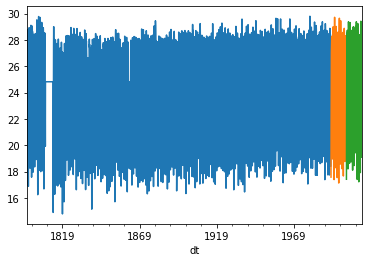

In [187]:
train.temp.plot()
validate.temp.plot()
test.temp.plot()

In [188]:
train.head()

,temp
dt,
1796-01-01,18.009
1796-02-01,20.291
1796-03-01,23.330
1796-04-01,27.008
1796-05-01,28.477


<AxesSubplot:xlabel='dt'>

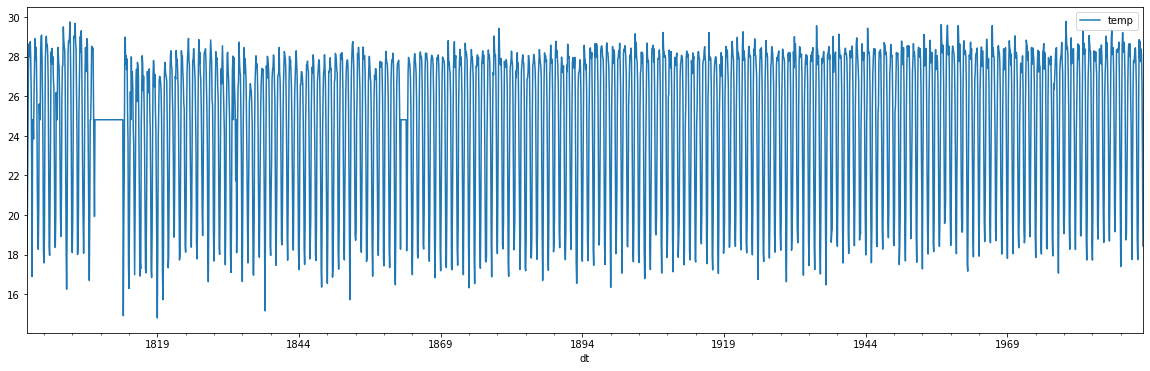

In [189]:

train.plot(figsize=(20,6))

<AxesSubplot:xlabel='dt'>

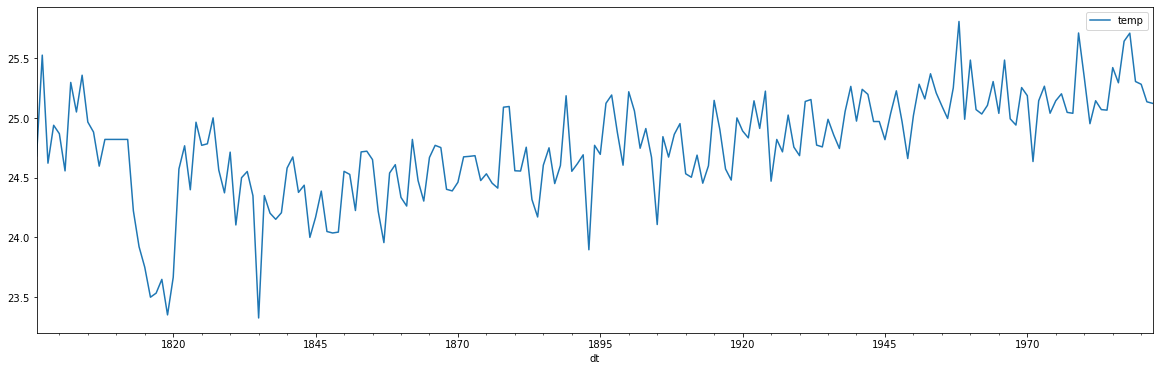

In [190]:
train.resample('1Y').mean().plot(figsize=(20,6))

### Takeaways
* looking over a large time scale shows a compact average temperature
* changing sampling by year shows up and down shifts in the temperature by 1 or 2 degrees
* resample by 10 year time average temp shows large increase over time 
* let's check for temperature seasonality.

<AxesSubplot:xlabel='dt'>

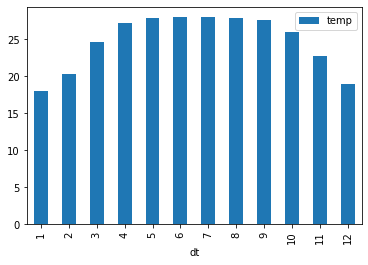

In [191]:
train.groupby(train.index.month).mean().plot.bar()

In [192]:
result = sm.tsa.seasonal_decompose(train.temp)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal, 
    'resid': result.resid,
})

decomposition.head()

,y,trend,seasonal,resid
dt,,,,
1796-01-01,18.009,NaN,-6.744077,NaN
1796-02-01,20.291,NaN,-4.411737,NaN
1796-03-01,23.330,NaN,-0.087354,NaN
1796-04-01,27.008,NaN,2.438211,NaN
1796-05-01,28.477,NaN,3.118907,NaN


<AxesSubplot:xlabel='dt'>

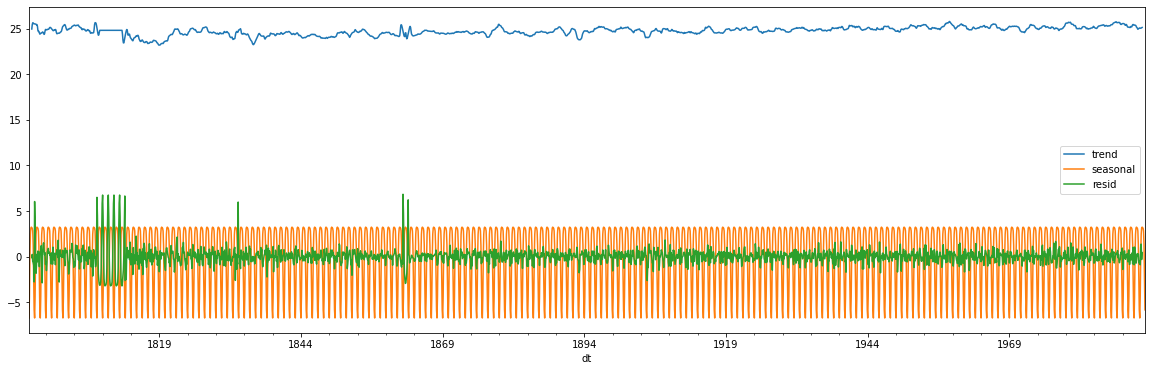

In [193]:
decomposition.iloc[:, 1:].plot(figsize=(20,6))

##  Explore Overall Takeaways
* looking over a large time scale shows a compact average temperature
* changing sampling by year shows up and down shifts in the temperature by 1 or 2 degrees
* resample by 10 year time average temp shows large increase over time 
* let's check for temperature seasonality.
* Lower temperatures in the back half of the year

# Model
* Immediately chose to use previous year modeling type, because the seasonality of the temperatures seems to have held up over time
* The yearly variance in temperate also seems to roughly simliar over time

## Score on Validate

In [194]:
def evaluate(target_var, df, yhat):
    rmse = round(sqrt(mean_squared_error(df[target_var], yhat[target_var])), 0)
    return rmse 

def plot_and_eval(target_var, train, validate, yhat):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth =1)
    plt.plot(yhat[target_var])
    plt.title(target_var)

    rmse = evaluate(target_var, validate, yhat)
    print(target_var, '--RMSE: {:.0f}'.format(rmse))

def append_eval_df(eval_df, model_type, target_var, df, yhat):
    
    rmse = evaluate(target_var, df, yhat)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)

    return eval_df.append(d, ignore_index=True)

eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])


In [197]:
yhat_df = round(train['1983':'1992'] + train.diff(12).mean(), 2)

In [198]:
yhat_df.index = validate.index

### Using Previous Years as predictor

temp --RMSE: 1


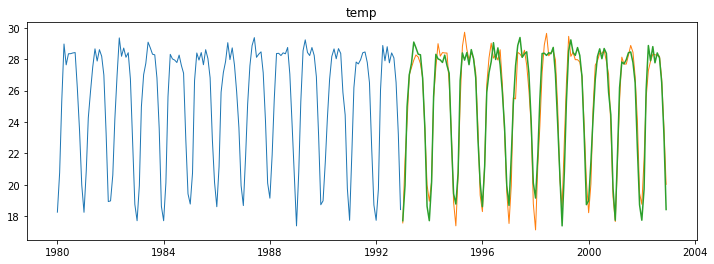

In [210]:
for col in train.columns:
    plot_and_eval(col, train['1980':], validate, yhat_df)
    eval_df = append_eval_df(eval_df, model_type='previous_year', 
                            target_var=col,
                            df=validate, 
                            yhat=yhat_df)

## Score on Test

In [202]:
yhat_test = validate + test.diff(12).mean()
yhat_test.index = test.index

In [203]:
# set up variables for scoring test predictions
rmse_temp = round(sqrt(mean_squared_error(test['temp'], yhat_test['temp'])), 0)

In [207]:
def plot_and_eval_test(target_var, train, validate, test, yhat):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth =1)
    plt.plot(test[target_var], label='Test', linewidth=1)
    plt.plot(yhat[target_var], label='Predictions')
    plt.title(target_var)
    plt.legend()
    plt.show(0)

rmse - temperature:  1.0


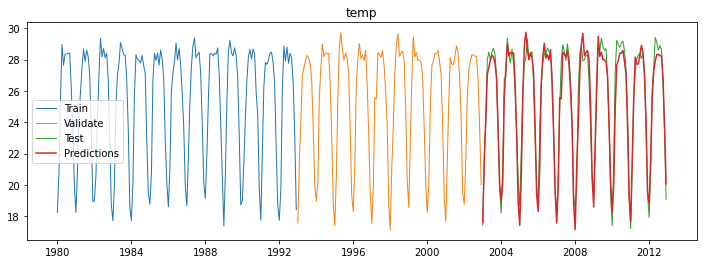

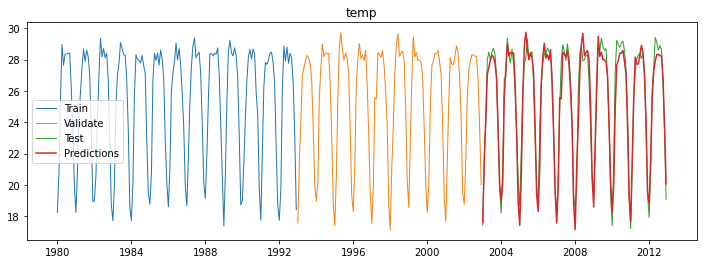

In [211]:
print('rmse - temperature: ', rmse_temp)

for col in train.columns:
    plot_and_eval_test(col, train['1980':], validate, test, yhat_test)

### Takeaways
* Using `previous_year` for the model type was a good call as we were able to get within 1 degree for our RMSE over a 10 year time frame.  

# Conclusion

* We were able to get within 1 degree for our RMSE in regards to a 10 year window for predicting average monthly temperatures
* Overtime the average temps in Bangladesh appear to be slowly rising, and our model performs in line with that expectation